# Two fields

We demonstrate the gridding of fields with `cygrid`, using HI data from EBHIS and far-infrared data from Planck. In this example, we grid one image onto another

We start by adjusting the notebook settings.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

We attempt to limit our dependencies as much as possible, but [`astropy`](https://astropy.readthedocs.org/en/stable/) and [`wcsaxes`](http://wcsaxes.readthedocs.org) needs to be available on your machine if you want to re-run the calculations. We can highly recommend [`anaconda`](https://www.continuum.io/downloads) as a scientific `python` platform.

In [2]:
import numpy as np
import matplotlib.pyplot as pl
from matplotlib import rcParams

from astropy.io import fits
from astropy.coordinates import SkyCoord
# We'll be loading some data from skyview, hence the longer timeout
from astropy.utils.data import conf
conf.remote_timeout = 60.
from wcsaxes import WCS

import cygrid

We change the `matplotlib` settings to improve and standardise our plots.

In [3]:
params = {
    'backend': 'pdf',
    'text.latex.preamble': ['\usepackage{gensymb}'],
    'axes.labelsize': 8,
    'axes.titlesize': 8,
    'font.size': 8,
    'legend.fontsize': 8,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'font.family': 'serif',
    'figure.dpi': 150
}

rcParams.update(params)

Let's furthermore define some plotting `kwargs` for the images.

In [5]:
imkw = dict(
    origin='lower',
    cmap='YlGnBu_r',
    interpolation='None')

For this demonstration, we show how to grid data from a large fits-file onto another one with a different extent and coordinate system.
First, we need to obtain our input image. We use `skyview` to get an image of Planck 857 GHz data in galactic coordinates.

In [26]:
input_data, input_header = fits.getdata(
    'http://skyview.gsfc.nasa.gov/current/cgi/runquery.pl?Survey=Planck+857&position=177.,61.&coordinates=J2000&pixels=500&Return=FITS',
    header=True)

Here's how our input datalook like:

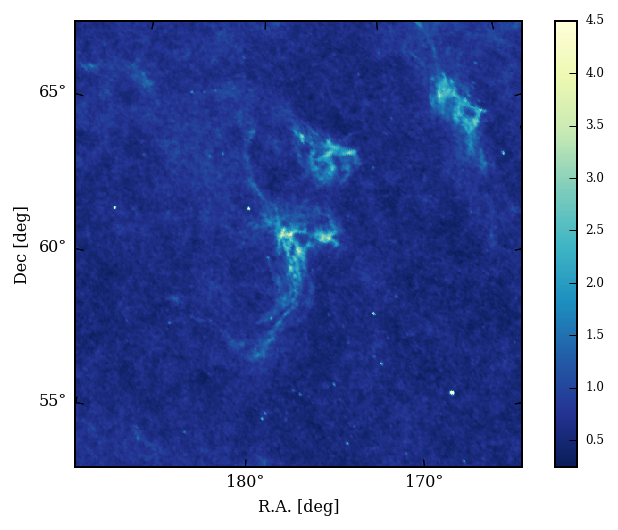

In [27]:
input_wcs = WCS(input_header)
fig = pl.figure()
ax = fig.add_subplot(111, projection=input_wcs)
lon, lat = ax.coords
im = ax.imshow(input_data, vmax=4.5, **imkw)
pl.colorbar(im, ax=ax)
lon.set_axislabel('R.A. [deg]')
lat.set_axislabel('Dec [deg]')

We download the EBHIS HI data onto which we will grid the Planck data. Note that we select a different coordinate system.

In [41]:
target_data, target_header = fits.getdata(
    'http://skyview.gsfc.nasa.gov/current/cgi/runquery.pl?Survey=EBHIS&position=135.,54.&coordinates=galactic&pixels=300&Return=FITS', header=True)

And here is how our target field looks like. It is rotated by ~180 degree, but the prominant feature in the centre is similar to the one shown in the Planck data.

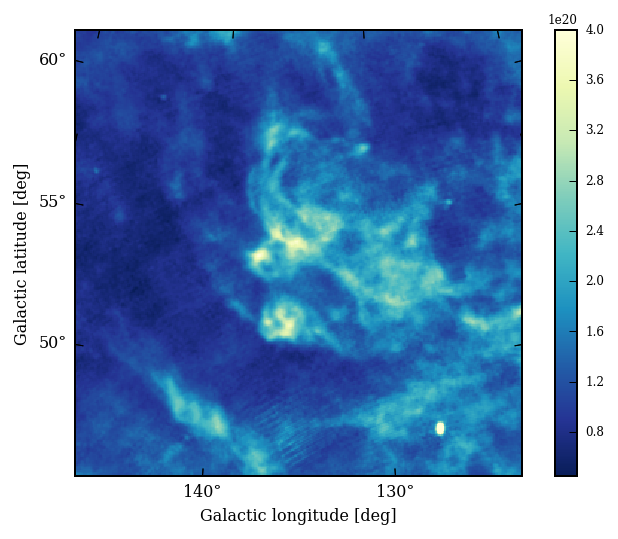

In [42]:
target_wcs = WCS(target_header)
fig = pl.figure()
ax = fig.add_subplot(111, projection=target_wcs)
lon, lat = ax.coords
im = ax.imshow(target_data, vmax=4.e20, **imkw)
pl.colorbar(im, ax=ax)
lon.set_axislabel('Galactic longitude [deg]')
lat.set_axislabel('Galactic latitude [deg]')

We start the gridding by initating the gridder with the `target_header`. Prior to this, we need to add a third axis to this header because `cygrid` was designed for three-dimensional data.

We might change this in the future, but this work-around is required until then.

In [43]:
target_header_3d = target_header.copy()
target_header_3d['NAXIS'] = 3
target_header_3d['NAXIS3'] = 1

gridder = cygrid.WcsGrid(target_header_3d)

To grid one image onto another, we need the coordinates for each pixel in the input image. To obtain these, we start by getting pixel coordinates with `np.meshgrid`.

In [44]:
input_lon_pix, input_lat_pix = np.meshgrid(np.arange(input_header['NAXIS1']), np.arange(input_header['NAXIS2']))

Next, we convert these from pixel- to world-coordinates, using the `wcs` features from `astropy`.

In [45]:
input_lon_world, input_lat_world = input_wcs.all_pix2world(input_lon_pix, input_lat_pix, 0)

Lastly, we convert the coordinates from equatorial to galactic. This is really simple and straightforward as well.

In [46]:
coords_eq = SkyCoord(input_lon_world, input_lat_world, frame='icrs', unit='deg')
coords_gal = coords_eq.galactic

The gridding kernel is of key importance for the entire gridding process. `cygrid` allows you to specify the shape of the kernel (e.g. elliptical Gaussian or tapered sinc) and its size.

In our example, we use a symmetrical Gaussian (i.e. the major and minor axis of the kernel are identical). In that case, we need to furthermore specify `kernelsize_sigma`, the `sphere_radius` up to which the kernel will be computed, and the maximum acceptable healpix resolution for which we recommend `kernelsize_sigma/2`.

We refer to section 3.5 of the paper ('a minimal example') for a short discussion of the kernel parameters.

In [48]:
kernelsize_fwhm = 2.5/60.
kernelsize_sigma = kernelsize_fwhm / 2.355 # https://en.wikipedia.org/wiki/Full_width_at_half_maximum
sphere_radius = 3. * kernelsize_sigma

gridder.set_kernel(
    'gauss1d',
    (kernelsize_sigma,),
    sphere_radius,
    kernelsize_sigma / 2.
    )

After the kernel has been set, we perform the actual gridding by calling `grid()` with the flattened coordinates and the data. Note that we need to add an artifical third axis to the `input_data`.

In [49]:
gridder.grid(
    coords_gal.l.value.flatten(),
    coords_gal.b.value.flatten(),
    input_data.reshape(-1, 1))

To get the gridded data, we simply call `get_datacube()`. We get rid of the degenerate third axis by using `squeeze()`.

In [50]:
datacube = gridder.get_datacube().squeeze()

/Users/dlenz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


Here's how the gridded Planck field looks like, superposed with contours from the HI data onto which we gridded our Planck data.

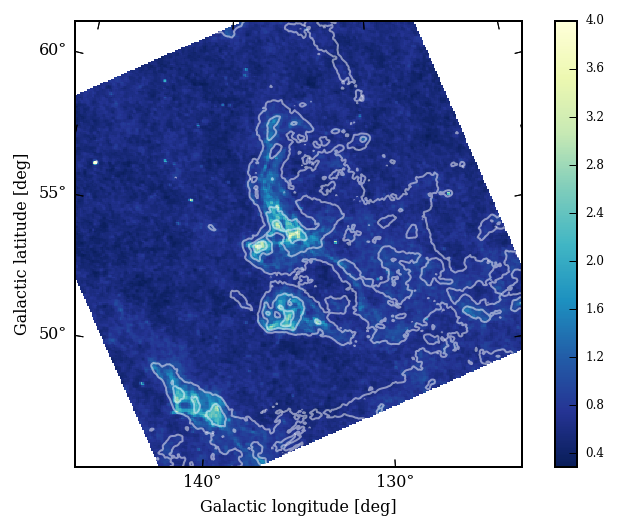

In [61]:
fig = pl.figure()
ax = fig.add_subplot(111, projection=target_wcs)
lon, lat = ax.coords
im = ax.imshow(datacube, vmax=4., **imkw)
pl.colorbar(im, ax=ax)
ax.contour(target_data, colors='white', levels=np.arange(1.5e20, 1.e21, 8.e19), alpha=0.5)
lon.set_axislabel('Galactic longitude [deg]')
lat.set_axislabel('Galactic latitude [deg]')

Finally, we can write the fits-image to disk:

In [62]:
fits.writeto('planck_to_ebhis.fits', datacube, target_wcs.celestial.to_header(), clobber=True)